# **C-calculate_correlation_between_ENSO_and_onset_date.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 28th, 2023

Last modified: July 28th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# **<font color='red' size=5>0. download and import packages</font>**

In [1]:
import platform
if platform.system() == 'Linux':
    !pip install cdsapi --quiet
    !pip install imageio[ffmpeg] --quiet
    !pip install imageio[pyav] --quiet

In [2]:
# 1. downloaad
import cdsapi                         # download from Climate Data Store, ECMWF
import pooch, urllib.request          # download from any available URL
import s3fs, boto3, botocore          # download from S3 server, Amazon Web Service
from pythia_datasets import DATASETS  # download certain content from pythia

# 2. useful toolkits
from itertools import product
import os, sys, glob, time, tempfile

# 3. read and write
import h5py

# 4. data processing
from scipy import stats
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
second_per_day = 86400

# **<font color='red' size=5>1. read data</font>**

## **<font size=5>1.1. precipitation</font>**

### **<font size=4>Yang: option 2 is the ERA5 ReAnalysis Data under the folder `Data/ERA5/monthly/single_level/1979_2023_SM.nc` with time resolution of 1-day.</font>**

In [4]:
file_path = os.path.join('Data', 'ERA5', 'hourly', 'single_level', '1979-2023_SH.nc')
ds = xr.open_dataset(file_path).squeeze()
ds

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 101, time: 5350)
Coordinates:
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 129.5 129.8 130.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -9.5 -9.75 -10.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-02-28
Data variables:
    crr        (time, latitude, longitude) float32 ...
    lsrr       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-27 21:52:07 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## **<font size=5>1.2. landmask**

In [5]:
landmask = np.isnan(xr.open_dataset(os.path.join('Data', 'ERA5', 'monthly', 'single_level', '1979-2023_SM.nc')).sel(expver=1).isel(time=0).squeeze().sst).values
landmask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## **<font size=5>1.3. ENSO Index</font>**

### **<font size=4>Yang: option 2 is to calculate the ONI using the file `sst.mnmean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [10]:
# data source 1: NCEP-NCAR v1 SST
ds_sst = xr.open_dataset(os.sep + os.path.join('home', 'jovyan', 'shared', 'Data', 'Projects', 'ENSO', 'sst.mnmean.nc'))
ds_sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2034, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-07-03

# **<font color='red' size=5>2. calculate the onset date of monsoon</font>**

**<font size=4 face='Arial' color='002DE5'>The onset date is calculated from August 1st. It is the first day of the first 5-day sequence receiving at least 40 mm of rainfall, and within the following 30 days from that date, there should not be a dry 10-day sequence with a cumulative rainfall of less than 5 mm.</font>**

In [6]:
def deg_suffix(deg, m='lon'):
    if m == 'lon':
        DEG = str(deg) + (' °W' if deg < 0 else (' °E' if deg > 0 else ''))
    elif m == 'lat':
        DEG = str(deg) + (' °S' if deg < 0 else (' °N' if deg > 0 else ''))
    else:
        DEG = str(deg)
    return DEG

In [7]:
def find_onset_date(ds, year=None, longitude=109, latitude=0):
    time_idx = ((ds.time.dt.year == year)&(ds.time.dt.month >= 11))|((ds.time.dt.year == year + 1)&(ds.time.dt.month <= 2))
    prcp = (ds.crr.sel(time=time_idx) + ds.lsrr.sel(time=time_idx)) * second_per_day
    prcp_series = prcp.sel(longitude=longitude, latitude=latitude, method='nearest').squeeze()
    
    # array used to find the onset date of monsoon
    larger_than_40mm = np.where(prcp_series < 40, 0, 1)
    less_than_5mm    = np.where(prcp_series >  5, 0, 1)

    ten_dry_days = np.zeros(prcp_series.shape)
    # some easy conditional operation
    for i in range(0, len(prcp_series)):
        if len(less_than_5mm[i:(i + 10)]) < 10:
            ten_dry_days[i] = np.nan
            continue
        if sum(less_than_5mm[i:(i + 10)]) == 10:
            ten_dry_days[i] = 1

    drought_signal = np.zeros(prcp_series.shape)
    # some easy conditional operation
    for i in range(0, len(prcp_series)):
        if len(ten_dry_days[i:(i + 30)]) < 30:
            drought_signal[i] = np.nan
            continue
        if sum(ten_dry_days[i:(i + 30)]) > 0:
            drought_signal[i] = 1
    
    monsoon_onset = np.zeros(prcp_series.shape)
    for idx in range(0, len(prcp_series)):
        if len(prcp_series[idx:(idx + 30)]) < 30:
            monsoon_onset[(idx + 1):] = np.nan
            break
        # print(f"date: {prcp_series.time.values[idx]}; larger than 40 mm: {larger_than_40mm[idx]==1}; drought: {drought_signal[idx]==1}")
        if (larger_than_40mm[idx] * (1 - drought_signal[idx])):
            monsoon_onset[idx] = 1
            monsoon_onset[(idx + 1):] = np.nan
            break
        else:
            monsoon_onset[idx] = np.nan

    onset_date = datetime.strptime(np.datetime_as_string(prcp_series.time.values[idx], unit='s'), '%Y-%m-%dT%H:%M:%S')
    normal_onset_date = datetime(year, 12, 10)
    day_delay = (onset_date - normal_onset_date).days
    # print(f"{onset_date.strftime('%Y-%m-%d')} is the onset date of monsoon this year. ")
    return day_delay, onset_date

In [8]:
# specify a location: (120.25°E, 3.5°S), and a time period (Nov, 1998 - Feb, 1999)
day_delay_list, onset_date_list = [], []

for year in range(1979, 2022 + 1):
    day_delay, onset_date = find_onset_date(ds, year=year, longitude=120.25, latitude=-3.50)
    day_delay_list.append(day_delay), onset_date_list.append(onset_date)
day_delay_array, onset_date_array = np.array(day_delay_list), np.array(onset_date_list)
da_day_delay  = xr.DataArray( day_delay_array, coords=[pd.date_range(start='1979', end='2022', freq='AS')], dims=['time'])
da_onset_date = xr.DataArray(onset_date_array, coords=[pd.date_range(start='1979', end='2022', freq='AS')], dims=['time'])

ds_onset = xr.Dataset({'delay': da_day_delay, 'onset_date': da_onset_date})
ds_onset

<xarray.Dataset>
Dimensions:     (time: 44)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2022-01-01
Data variables:
    delay       (time) int64 -12 -2 -22 2 -25 -15 -25 ... -16 -13 8 -15 -26 -10
    onset_date  (time) datetime64[ns] 1979-11-28 1980-12-08 ... 2022-11-30

# **<font color='red' size=5>3. calculate ONI</font>**

In [18]:
nino_region       = [190.0, 240.0,  -5.0,  5.0]

climatology = ds_sst.sst.sel(time=slice('1981', '2010'),
                              lat=slice(nino_region[-1], nino_region[-2]), 
                              lon=slice(nino_region[ 0], nino_region[ 1])
                            ).mean('time')

sst_anom_series_nino = []
for year in range(1979, 2022+1):
    sst_temp_nino = ds_sst.sst.sel(time=slice(f'{year}-11', f'{year + 1}-02'), 
                                    lat=slice(nino_region[-1], nino_region[-2]), 
                                    lon=slice(nino_region[ 0], nino_region[ 1]))

    sst_anom_temp_nino = sst_temp_nino - climatology
    sst_anom_series_nino.append(sst_anom_temp_nino.mean(dim=['lon', 'lat']).mean(dim=['time']))

sst_anom_series_nino = np.array(sst_anom_series_nino)
sst_anom_series_nino.shape

(44,)

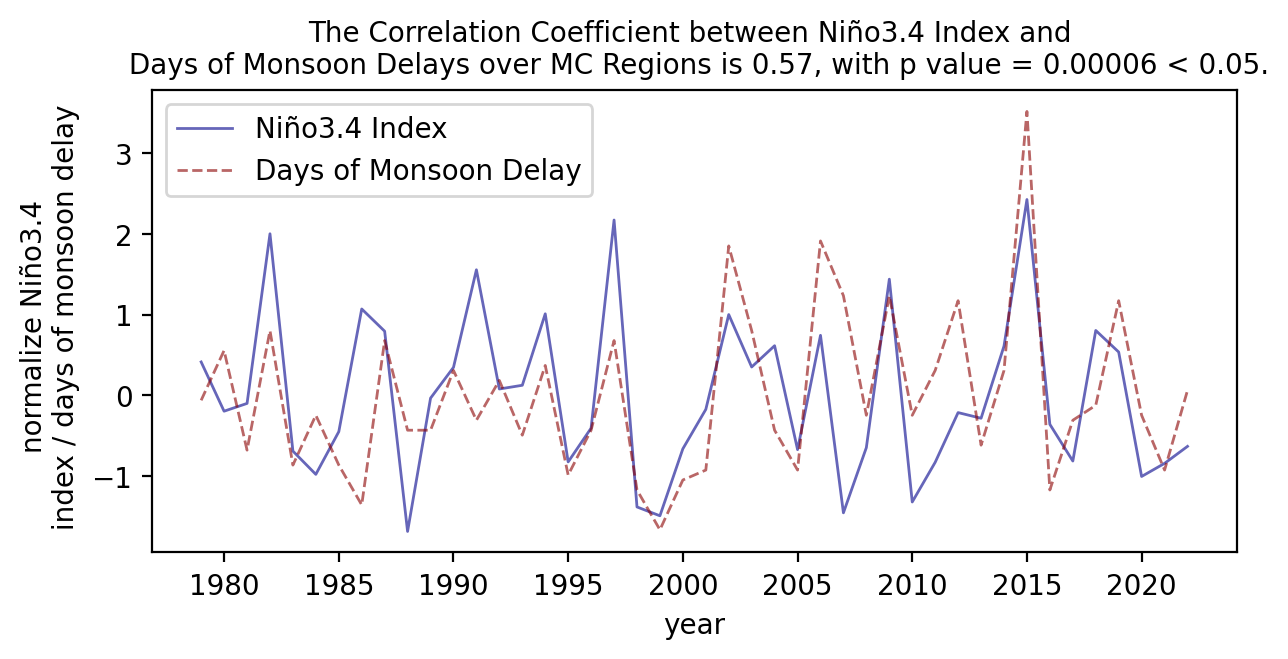

In [36]:
r, p_val = stats.pearsonr(ds_onset.delay.values, sst_anom_series_nino)

fig, ax = plt.subplots(figsize=(7, 3), dpi=200)
z_sst_anom_series_nino = (sst_anom_series_nino - sst_anom_series_nino.mean()) / sst_anom_series_nino.std()
z_delay = (ds_onset.delay.values - ds_onset.delay.values.mean()) / ds_onset.delay.values.std()
ax.plot(ds_onset.time, z_sst_anom_series_nino, 
        linewidth=1, linestyle='solid', 
        color='darkblue', alpha=0.6, 
        label='Niño3.4 Index')
ax.plot(ds_onset.time, z_delay, 
        linewidth=1, linestyle='dashed', 
        color='darkred', alpha=0.6, 
        label='Days of Monsoon Delay')

ax.set_xlabel('year')
ax.set_ylabel('normalize Niño3.4 \n index / days of monsoon delay')
ax.legend(loc='best')
ax.set_title(f"The Correlation Coefficient between Niño3.4 Index and \n Days of Monsoon Delays over MC Regions is {r:.02f}, with p value = {p_val:.05f} < 0.05.", 
             size=10)

plt.savefig(os.path.join('Figure', 'corr_btwn_oni_and_delay.png'), dpi=200)